Total_Turnover: 3422065.0586887286  
Total_PnL: 147777.01029799972  
Total_Commission: 72974.63452212434  
Total_Net_PnL: 74802.37577587538  

In [1]:
import pandas as pd, numpy as np

In [2]:
df = pd.read_csv('horses.csv')

In [3]:
df.head()

,race_number,saddle_number,win_fair_price,win_starting_price,winner
0,1,4,1.7353,1.7098,1
1,1,1,6.0313,6.0914,0
2,1,5,7.6923,7.5101,0
3,1,6,20.3325,20.4978,0
4,1,2,23.9991,23.4710,0


In [4]:
df.tail()

,race_number,saddle_number,win_fair_price,win_starting_price,winner
86643,10000,7,14.4772,13.8269,0
86644,10000,5,29.0062,29.8636,0
86645,10000,3,50.8005,48.9715,0
86646,10000,9,310.1959,305.6448,0
86647,10000,2,621.1930,601.6791,0


In [5]:
df.dtypes

race_number             int64
saddle_number           int64
win_fair_price        float64
win_starting_price    float64
winner                  int64
dtype: object

In [6]:
len(df)

86648

### Calculate overlay
As an example if the *win_starting_price* is the price that the bookmaker offers on the horse as it starts the race and if our own probability of the horse winning is the *win_fair_price* we calculate the value (overlay):  
`( (1 / win_fair_price )% multiplied by win_starting_price)) - 100%.`

In [7]:
estimated_prob_winning = (1 / df["win_fair_price"])
odds = df["win_starting_price"]
df["overlay"] = (estimated_prob_winning * odds) - 1
df

,race_number,saddle_number,win_fair_price,win_starting_price,winner,overlay
0,1,4,1.7353,1.7098,1,-0.014695
1,1,1,6.0313,6.0914,0,0.009965
2,1,5,7.6923,7.5101,0,-0.023686
3,1,6,20.3325,20.4978,0,0.008130
4,1,2,23.9991,23.4710,0,-0.022005
...,...,...,...,...,...,...
86643,10000,7,14.4772,13.8269,0,-0.044919
86644,10000,5,29.0062,29.8636,0,0.029559
86645,10000,3,50.8005,48.9715,0,-0.036004
86646,10000,9,310.1959,305.6448,0,-0.014672


### Kelly Criterion

The formula used to calculate the fraction for a lay bet is:
Full Lay Kelly = $ f = (q - p × (d - 1)) / (d - 1) $ where 
- f = fraction of the current bank to wager.  
- d = decimal betting odds.
- p = perceived probability of selection winning.
- q = perceived probability of selection losing, which is 1 – p.

The formula used to calculate the fraction for a back bet is:
Full Back Kelly = $ f = (p × (d – 1) – q) / (d – 1) $ where

- f = fraction of the current bank to wager.
- d = decimal betting odds.
- p = perceived probability of selection winning.
- q = perceived probability of selection losing, which is 1 – p.  

Betting full Kelly we can also calculate the stake as: `bankroll * (overlay/(odds - 1))` where overlay is the absolute value

In [8]:
overlay_is_null = df["overlay"].isnull()
print(overlay_is_null.value_counts())
overlay_is_not_null = df["overlay"].notnull()
print(overlay_is_not_null.value_counts())

False    86648
Name: overlay, dtype: int64
True    86648
Name: overlay, dtype: int64


In [9]:
%timeit df["side"] = np.where(df["overlay"] > 0, "back", "lay") # 5.59 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# %timeit df["side"] = ["lay" if x < 0 else "back" for x in df["overlay"]] # 14.6 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# %timeit df["side"] = df["overlay"].apply(lambda x: "lay" if x < 0 else "back") # 16.6 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# %timeit df["side"] = df["overlay"].map( lambda x: "lay" if x < 0 else "back") # 17.7 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# df.loc[df["overlay"] < 0, "kelly"] = 10000 * ((df["overlay"] * (-1)) / (odds - 1))
# df.loc[df["overlay"] > 0, "kelly"] = 10000 * (df["overlay"] / (odds - 1))
df["kelly"] = np.where(df["overlay"] < 0, 10000 * ((df["overlay"] * (-1)) / (odds - 1)), 10000 * (df["overlay"] / (odds - 1)))

5.62 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Turnover

In [10]:
# df.loc[df["kelly"] > 2, "turnover"] = df["kelly"]
# df.loc[df["kelly"] < 2, "turnover"] = 0
df["turnover"] = np.where(df["kelly"] > 2, df["kelly"], 0)
df

,race_number,saddle_number,win_fair_price,win_starting_price,winner,overlay,side,kelly,turnover
0,1,4,1.7353,1.7098,1,-0.014695,lay,207.028254,207.028254
1,1,1,6.0313,6.0914,0,0.009965,back,19.571600,19.571600
2,1,5,7.6923,7.5101,0,-0.023686,lay,36.383502,36.383502
3,1,6,20.3325,20.4978,0,0.008130,back,4.169620,4.169620
4,1,2,23.9991,23.4710,0,-0.022005,lay,9.792618,9.792618
...,...,...,...,...,...,...,...,...,...
86643,10000,7,14.4772,13.8269,0,-0.044919,lay,35.019301,35.019301
86644,10000,5,29.0062,29.8636,0,0.029559,back,10.240995,10.240995
86645,10000,3,50.8005,48.9715,0,-0.036004,lay,7.505203,7.505203
86646,10000,9,310.1959,305.6448,0,-0.014672,lay,0.481600,0.000000


### Expected Value

In [11]:
back_bets = df["side"] == "back"
# df.loc[back_bets, "EV"] = (estimated_prob_winning * ((odds - 1) * df["kelly"])) - ((1 - estimated_prob_winning) * df["kelly"])
lay_bets = df["side"] == "lay"
# df.loc[lay_bets, "EV"] = ((1 - estimated_prob_winning) * df["kelly"]) - (estimated_prob_winning * ((odds - 1) * df["kelly"]))
EV_backers = (estimated_prob_winning * ((odds - 1) * df["kelly"])) - ((1 - estimated_prob_winning) * df["kelly"])
EV_layers = ((1 - estimated_prob_winning) * df["kelly"]) - (estimated_prob_winning * ((odds - 1) * df["kelly"]))
df["EV"] = np.where(back_bets, EV_backers, EV_layers)
df

,race_number,saddle_number,win_fair_price,win_starting_price,winner,overlay,side,kelly,turnover,EV
0,1,4,1.7353,1.7098,1,-0.014695,lay,207.028254,207.028254,3.042252
1,1,1,6.0313,6.0914,0,0.009965,back,19.571600,19.571600,0.195025
2,1,5,7.6923,7.5101,0,-0.023686,lay,36.383502,36.383502,0.861780
3,1,6,20.3325,20.4978,0,0.008130,back,4.169620,4.169620,0.033898
4,1,2,23.9991,23.4710,0,-0.022005,lay,9.792618,9.792618,0.215486
...,...,...,...,...,...,...,...,...,...,...
86643,10000,7,14.4772,13.8269,0,-0.044919,lay,35.019301,35.019301,1.573029
86644,10000,5,29.0062,29.8636,0,0.029559,back,10.240995,10.240995,0.302716
86645,10000,3,50.8005,48.9715,0,-0.036004,lay,7.505203,7.505203,0.270214
86646,10000,9,310.1959,305.6448,0,-0.014672,lay,0.481600,0.000000,0.007066


### PnL

In [12]:
back_winners = (df["winner"] == 1) & (df["side"] == "back")
back_losers = (df["winner"] == 0) & (df["side"] == "back")
lay_winners = (df["winner"] == 0) & (df["side"] == "lay")
lay_losers = (df["winner"] == 1) & (df["side"] == "lay")

# df.loc[back_winners, "PnL"] = df["turnover"] * ( odds - 1 ) 
# df.loc[back_losers, "PnL"] = -df["turnover"]
# df.loc[lay_winners, "PnL"] = df["turnover"]
# df.loc[lay_losers, "PnL"] = -df["turnover"] * ( odds - 1 )

conditions = [
    back_winners,
    back_losers,
    lay_winners,
    lay_losers]
choices = [df["turnover"] * ( odds - 1 ), -df["turnover"], df["turnover"], -df["turnover"] * ( odds - 1 )]
df["PnL"] = np.select(conditions, choices)

print(back_winners.value_counts() + back_losers.value_counts() + lay_winners.value_counts() + lay_losers.value_counts())
df

False    259944
True      86648
dtype: int64


,race_number,saddle_number,win_fair_price,win_starting_price,winner,overlay,side,kelly,turnover,EV,PnL
0,1,4,1.7353,1.7098,1,-0.014695,lay,207.028254,207.028254,3.042252,-146.948654
1,1,1,6.0313,6.0914,0,0.009965,back,19.571600,19.571600,0.195025,-19.571600
2,1,5,7.6923,7.5101,0,-0.023686,lay,36.383502,36.383502,0.861780,36.383502
3,1,6,20.3325,20.4978,0,0.008130,back,4.169620,4.169620,0.033898,-4.169620
4,1,2,23.9991,23.4710,0,-0.022005,lay,9.792618,9.792618,0.215486,9.792618
...,...,...,...,...,...,...,...,...,...,...,...
86643,10000,7,14.4772,13.8269,0,-0.044919,lay,35.019301,35.019301,1.573029,35.019301
86644,10000,5,29.0062,29.8636,0,0.029559,back,10.240995,10.240995,0.302716,-10.240995
86645,10000,3,50.8005,48.9715,0,-0.036004,lay,7.505203,7.505203,0.270214,7.505203
86646,10000,9,310.1959,305.6448,0,-0.014672,lay,0.481600,0.000000,0.007066,0.000000


### Commission, Net PnL & RoI

In [13]:
# 5% of your race PnL in each race that your race PnL is positive.
race_pnl = df.groupby("race_number")["PnL"].transform("sum")
race_size = df.groupby("race_number")["PnL"].transform("count")
commission = race_pnl * 0.05
df["commission"] = np.where(df.groupby("race_number")["PnL"].transform("sum") > 0, commission / race_size, 0)
df["Net PnL"] = df["PnL"] - df["commission"]
df.loc[df["turnover"] == 0, "RoI"] = 0
df.loc[df["turnover"] != 0, "RoI"] = df["Net PnL"] / df["turnover"]
df

,race_number,saddle_number,win_fair_price,win_starting_price,winner,overlay,side,kelly,turnover,EV,PnL,commission,Net PnL,RoI
0,1,4,1.7353,1.7098,1,-0.014695,lay,207.028254,207.028254,3.042252,-146.948654,0.0,-146.948654,-0.7098
1,1,1,6.0313,6.0914,0,0.009965,back,19.571600,19.571600,0.195025,-19.571600,0.0,-19.571600,-1.0000
2,1,5,7.6923,7.5101,0,-0.023686,lay,36.383502,36.383502,0.861780,36.383502,0.0,36.383502,1.0000
3,1,6,20.3325,20.4978,0,0.008130,back,4.169620,4.169620,0.033898,-4.169620,0.0,-4.169620,-1.0000
4,1,2,23.9991,23.4710,0,-0.022005,lay,9.792618,9.792618,0.215486,9.792618,0.0,9.792618,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86643,10000,7,14.4772,13.8269,0,-0.044919,lay,35.019301,35.019301,1.573029,35.019301,0.0,35.019301,1.0000
86644,10000,5,29.0062,29.8636,0,0.029559,back,10.240995,10.240995,0.302716,-10.240995,0.0,-10.240995,-1.0000
86645,10000,3,50.8005,48.9715,0,-0.036004,lay,7.505203,7.505203,0.270214,7.505203,0.0,7.505203,1.0000
86646,10000,9,310.1959,305.6448,0,-0.014672,lay,0.481600,0.000000,0.007066,0.000000,0.0,0.000000,0.0000


### Total Turnover, Total EV, Total PnL, Total Net PnL, Total RoI


In [14]:
Total_Turnover = df["turnover"].sum()
Total_PnL = df["PnL"].sum()
Total_Commission = df["commission"].sum()
Total_Net_PnL = df["Net PnL"].sum()
print(f'Total_Turnover: {Total_Turnover}')
print(f'Total_PnL: {Total_PnL}')
print(f'Total_Commission: {Total_Commission}')
print(f'Total_Net_PnL: {Total_Net_PnL}')

Total_Turnover: 3422065.0586887286
Total_PnL: 147777.01029799972
Total_Commission: 72974.63452212434
Total_Net_PnL: 74802.37577587538


### Running a Monte Carlo simulation

In [15]:
import random 

This is a very simplistic way of running a Monte Carlo simulation. I understand the idea is that you want to generate some random probability of winning and check how that impacts our PnL. What I have tried to do is:
- generate a random number between 0 and 1 for each bet
- if random number associated with each bet is less than the expected win probability, we have a winner = 1. Otherwise we should have a loss.

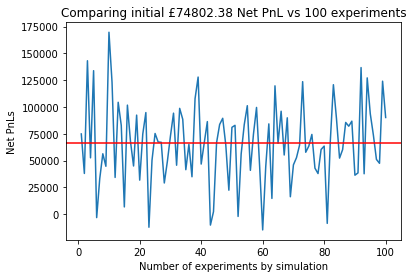

If we run 1 simulation x 100 experiments, on average Net PnL is £66371.96


In [16]:
# random simulations based on random numbers
import pandas as pd, numpy as np
import random
import matplotlib.pyplot as plt


def generate_betting_analysis_results(total_experiments):
    experiments_num = []
    results = []
    initial_df = pd.read_csv('horses.csv')
    
    # does not change
    estimated_prob_winning = 1 / initial_df["win_fair_price"]
    initial_df["estimated_prob_winning"] = estimated_prob_winning
    odds = initial_df["win_starting_price"]
    initial_df["overlay"] = (estimated_prob_winning * odds) - 1
    initial_df["side"] = np.where(initial_df["overlay"] > 0, "back", "lay")
    back_bets = initial_df["side"] == "back"
    lay_bets = initial_df["side"] == "lay"
    back_kelly = 10000 * (initial_df["overlay"] / (odds - 1))
    lay_kelly = 10000 * ((initial_df["overlay"] * (-1)) / (odds - 1))
    initial_df["kelly"] = np.where(initial_df["overlay"] > 0, back_kelly, lay_kelly)
    initial_df["turnover"] = np.where(initial_df["kelly"] >= 2, initial_df["kelly"], 0)
    
    for i in range(total_experiments):
        experiments_num.append(i+1)
        df = initial_df.copy()
        
    
        #determine winners: this does change for each iteration
        #skip below step for first iteration
        if i > 0:
            df["random_prob_winning"] = np.random.uniform(0,1, size=len(df))
            df["winner"] = np.where(estimated_prob_winning >= df["random_prob_winning"], 1, 0)
        
        back_winners = (df["winner"] == 1) & (df["side"] == "back")
        back_losers = (df["winner"] == 0) & (df["side"] == "back")
        lay_winners = (df["winner"] == 0) & (df["side"] == "lay")
        lay_losers = (df["winner"] == 1) & (df["side"] == "lay")
        pnl_back_winners = df["turnover"] * ( odds - 1 )
        pnl_back_back_losers = -df["turnover"]
        pnl_lay_winners = df["turnover"]
        pnl_lay_losers = -df["turnover"] * ( odds - 1 )
        
        pnl_conditions = [
            back_winners,
            back_losers,
            lay_winners,
            lay_losers]
        pnl_choices = [pnl_back_winners, pnl_back_back_losers, pnl_lay_winners, pnl_lay_losers]
        
        #calculate PnLs: this does change for each iteration
        df["PnL"] = np.select(pnl_conditions, pnl_choices)
    
        #calculate commissions and net PnLs: this does change for each iteration
        race_pnl = df.groupby("race_number")["PnL"].transform("sum")
        race_size = df.groupby("race_number")["PnL"].transform("count")
        commission = race_pnl * 0.05
        df["commission"] = np.where(df.groupby("race_number")["PnL"].transform("sum") > 0, commission / race_size, 0)
        df["Net PnL"] = df["PnL"] - df["commission"]
        
        Total_Net_PnL = df["Net PnL"].sum()
        results.append(Total_Net_PnL)
        

    plt.plot(experiments_num,results)
    return experiments_num, results

experiments, net_pnls = generate_betting_analysis_results(100)
simulation_average_net_pnl = sum(net_pnls)/len(net_pnls)
starting_net_pnl = net_pnls[0]

plt.title(f"Comparing initial £{starting_net_pnl:.2f} Net PnL vs {experiments[-1]} experiments")
plt.ylabel("Net PnLs")
plt.xlabel("Number of experiments by simulation")
plt.axhline(y = simulation_average_net_pnl, color = 'r', linestyle = '-')
plt.show()

print(f"If we run 1 simulation x {experiments[-1]} experiments, on average Net PnL is £{simulation_average_net_pnl:.2f}")

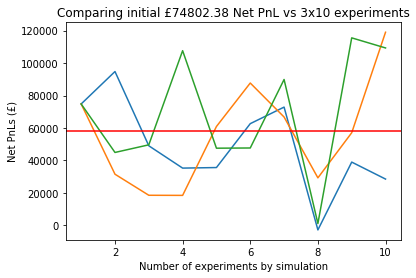

If we run 3 simulations x 10 experiments, on average Net PnL is £58073.64
Mean: 58073.63874106745
SD: 32626.39641141733
Max: 118957.18509501808
Min: -2748.274830489787


In [17]:
# random simulations based on random numbers
import pandas as pd, numpy as np
import random
import matplotlib.pyplot as plt

initial_df = pd.read_csv('horses.csv')

# does not change
estimated_prob_winning = 1 / initial_df["win_fair_price"]
initial_df["estimated_prob_winning"] = estimated_prob_winning
odds = initial_df["win_starting_price"]
initial_df["overlay"] = (estimated_prob_winning * odds) - 1
initial_df["side"] = np.where(initial_df["overlay"] > 0, "back", "lay")
back_bets = initial_df["side"] == "back"
lay_bets = initial_df["side"] == "lay"
back_kelly = 10000 * (initial_df["overlay"] / (odds - 1))
lay_kelly = 10000 * ((initial_df["overlay"] * (-1)) / (odds - 1))
initial_df["kelly"] = np.where(initial_df["overlay"] > 0, back_kelly, lay_kelly)
initial_df["turnover"] = np.where(initial_df["kelly"] >= 2, initial_df["kelly"], 0)


def generate_betting_analysis_results(total_experiments):
    
    experiments_num = []
    results = []
    
    for i in range(1, total_experiments + 1):
        experiments_num.append(i)
        df = initial_df.copy()
        
    
        #determine winners: this does change for each iteration
        #skip below step for first iteration
        if i > 1:
            df["random_prob_winning"] = np.random.uniform(0,1, size=len(df))
            df["winner"] = np.where(estimated_prob_winning >= df["random_prob_winning"], 1, 0)
        
        back_winners = (df["winner"] == 1) & (df["side"] == "back")
        back_losers = (df["winner"] == 0) & (df["side"] == "back")
        lay_winners = (df["winner"] == 0) & (df["side"] == "lay")
        lay_losers = (df["winner"] == 1) & (df["side"] == "lay")
        pnl_back_winners = df["turnover"] * ( odds - 1 )
        pnl_back_back_losers = -df["turnover"]
        pnl_lay_winners = df["turnover"]
        pnl_lay_losers = -df["turnover"] * ( odds - 1 )
        
        pnl_conditions = [
            back_winners,
            back_losers,
            lay_winners,
            lay_losers]
        pnl_choices = [pnl_back_winners, pnl_back_back_losers, pnl_lay_winners, pnl_lay_losers]
        
        #calculate PnLs: this does change for each iteration
        df["PnL"] = np.select(pnl_conditions, pnl_choices)
    
        #calculate commissions and net PnLs: this does change for each iteration
        race_pnl = df.groupby("race_number")["PnL"].transform("sum")
        race_size = df.groupby("race_number")["PnL"].transform("count")
        commission = race_pnl * 0.05
        df["commission"] = np.where(df.groupby("race_number")["PnL"].transform("sum") > 0, commission / race_size, 0)
        df["Net PnL"] = df["PnL"] - df["commission"]
        
        Total_Net_PnL = df["Net PnL"].sum()
        results.append(Total_Net_PnL)
        

    plt.plot(experiments_num,results)
    return results



num_simulations = 3
total_experiments = 10
simulation_df = pd.DataFrame()

for n in range(1, num_simulations + 1):
    net_pnls = generate_betting_analysis_results(total_experiments)
    simulation_df[n] = net_pnls

    
simulation_average_net_pnl = simulation_df.stack().mean()
simulation_sd_net_pnl = simulation_df.stack().std()
simulation_max_net_pnl = simulation_df.stack().max()
simulation_min_net_pnl = simulation_df.stack().min()
starting_net_pnl = net_pnls[0]

plt.title(f"Comparing initial £{starting_net_pnl:.2f} Net PnL vs {num_simulations}x{total_experiments} experiments")
plt.ylabel("Net PnLs (£)")
plt.xlabel("Number of experiments by simulation")
plt.axhline(y = simulation_average_net_pnl, color = 'r', linestyle = '-')
plt.show()

print(f"If we run {num_simulations} simulations x {total_experiments} experiments, on average Net PnL is £{simulation_average_net_pnl:.2f}")
print(f"Mean: {simulation_average_net_pnl}")
print(f"SD: {simulation_sd_net_pnl}")
print(f"Max: {simulation_max_net_pnl}")
print(f"Min: {simulation_min_net_pnl}")